<a href="https://colab.research.google.com/github/Daye24/phenotype-classification-ML/blob/main/phenotype_classifier_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phenotype Classifier Notebook
This notebook explores the synthetic dataset and builds a Random Forest model.

In [3]:
!git clone https://github.com/Daye24/phenotype-classification-ML.git
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv("phenotype-classification-ML/data/dataset.csv")
df.head()


Cloning into 'phenotype-classification-ML'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 44 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (44/44), 239.35 KiB | 1.83 MiB/s, done.
Resolving deltas: 100% (9/9), done.


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,label
0,-0.950027,-4.823693,0.098040,0.176071,-3.405527,-4.515365,0.231272,-1.602994,-1.168142,0.566777,...,0.110691,-3.195430,-1.703170,-1.276106,0.705884,0.371630,2.032241,1.558405,2.274818,degenerating
1,-0.250303,1.473141,-0.356638,0.187378,-0.445104,-1.590974,-0.140981,0.287161,0.742004,0.240448,...,0.253887,-3.098526,1.485243,0.030873,-1.246679,0.669943,0.352109,-0.426326,3.406395,healthy
2,1.011340,-0.981668,-0.094143,-0.674892,-0.652019,-1.452816,0.738799,-0.473630,0.031785,0.749786,...,-0.577565,-2.156542,3.433031,0.464304,0.120664,0.754350,3.946145,-1.100095,-2.991957,degenerating
3,-1.879244,2.212891,0.657636,-0.014560,2.424188,-1.075100,0.232465,0.685069,2.935476,0.118778,...,1.389868,-1.840437,0.746267,-0.024023,-1.167365,-2.032974,2.018766,1.395564,3.124452,healthy
4,1.885076,0.450507,0.423559,3.452865,-0.937176,0.419032,0.111140,1.716358,2.150967,2.230818,...,-2.236426,-3.041974,2.023001,-2.353483,1.890523,0.300547,0.256510,1.459538,-2.466504,stressed


Basic Cleaning of Dataset

In [4]:
# drop any columns with >40% missing
threshold = len(df) * 0.4
df = df.dropna(thresh=threshold, axis=1)

# simple fill
df = df.fillna(df.median(numeric_only=True))

# encode label if not numeric
df['label'] = df['label'].astype('category').cat.codes


Basic Training of Dataset

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# Ensure the repository is cloned
repo_path = 'phenotype-classification-ML'
if not os.path.exists(repo_path):
    !git clone https://github.com/Daye24/phenotype-classification-ML.git

# Load the dataset
df = pd.read_csv(f"{repo_path}/data/dataset.csv")

# Basic Cleaning of Dataset
# drop any columns with >40% missing
threshold = len(df) * 0.4
df = df.dropna(thresh=threshold, axis=1)

# simple fill
df = df.fillna(df.median(numeric_only=True))

# encode label if not numeric
df['label'] = df['label'].astype('category').cat.codes

X = df.drop("label", axis=1)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [6]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

preds = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))


Accuracy: 0.775
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        68
           1       0.70      0.70      0.70        66
           2       0.83      0.86      0.84        66

    accuracy                           0.78       200
   macro avg       0.77      0.78      0.77       200
weighted avg       0.77      0.78      0.77       200



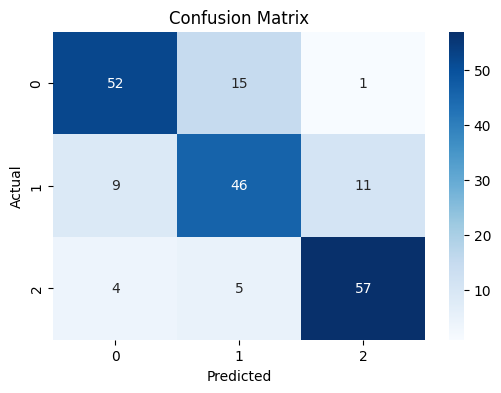

In [8]:
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


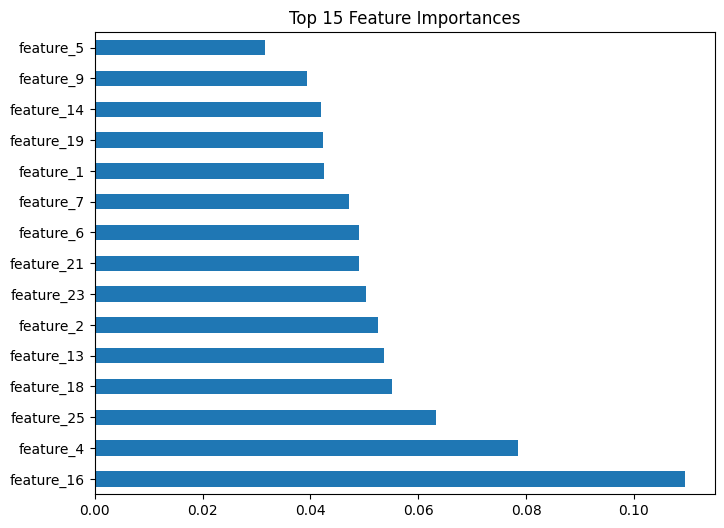

In [9]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.nlargest(15).plot(kind='barh', figsize=(8,6))
plt.title("Top 15 Feature Importances")
plt.show()


In [10]:
params = {
    "n_estimators": [100, 200, 500],
    "max_depth": [5, 10, 20, None]
}

grid = GridSearchCV(rf, params, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)


Best params: {'max_depth': 20, 'n_estimators': 500}


In [23]:
rf.predict_proba(X_test)


import shap
import numpy as np

# --- 1. Create TreeExplainer in safe mode ---
explainer = shap.TreeExplainer(rf, feature_perturbation="tree_path_dependent")

# --- 2. Compute SHAP values ---
shap_values = explainer.shap_values(X_test)

# Each class will have its own SHAP matrix of shape (n_samples, n_features)
print("Class 0 SHAP shape:", shap_values[0].shape)
print("Class 1 SHAP shape:", shap_values[1].shape)
print("Class 2 SHAP shape:", shap_values[2].shape)
print("X_test shape:", X_test.shape)







Class 0 SHAP shape: (25, 3)
Class 1 SHAP shape: (25, 3)
Class 2 SHAP shape: (25, 3)
X_test shape: (200, 25)


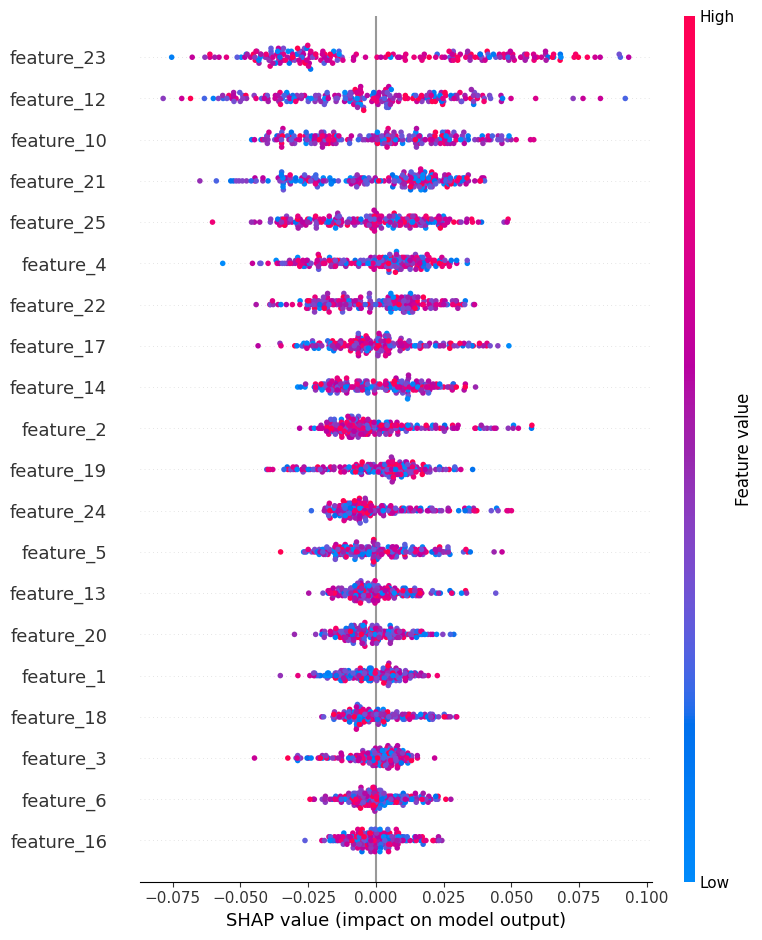

In [24]:
import numpy as np

# Convert SHAP output to a numerical array
shap_fixed = np.array(shap_values, dtype=float)

# Reshape to (3 classes, 200 samples, 25 features)
shap_fixed = shap_fixed.reshape(3, X_test.shape[0], X_test.shape[1])

# Average across classes
shap_combined = shap_fixed.mean(axis=0)

# Plot
shap.summary_plot(shap_combined, X_test)

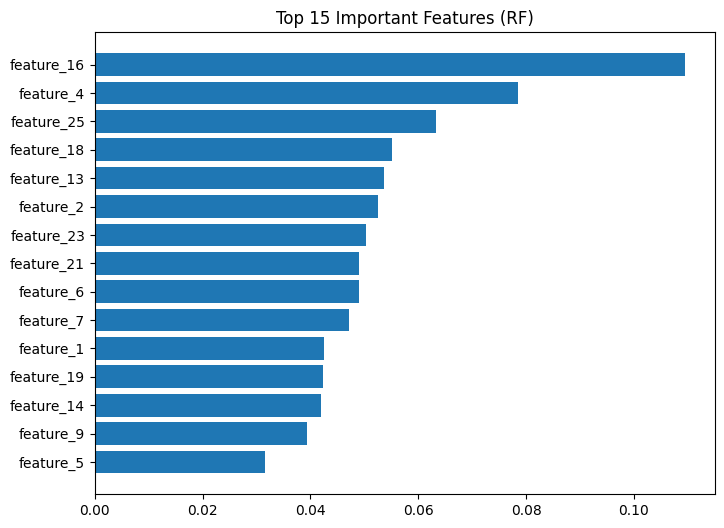

In [25]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 6))
plt.barh(range(15), importances[indices][:15])
plt.gca().invert_yaxis()
plt.yticks(range(15), X.columns[indices][:15])
plt.title("Top 15 Important Features (RF)")
plt.show()
